# PROYECTO FINAL WBDS LA Camp : Análisis exploratorio de proteínas relacionadas a melanoma en *Homo Sapiens*

## Planteamiento del problema

El cáncer es un gran conjunto de enfermedades caracterizado por el desarrollo de células anormales debido a mutaciones.
Estas mutaciones se encuentran en proteinas involucradas en mecanismos de regulación y crecimiento. Además debido a la mayor complejidad de los organismos eucariotas,ciertas isoformas podrían generar un mayor desarrollo del cáncer. En este proyecto,se realizará un análisis exploratorio en datos de Uniprot para analizar las proteínas relacionadas a melanoma, un tipo de cáncer que ocurre en los melanocitos, y proteínas del proteoma humano que presenten secuencias similares, teniendo en cuenta los dominios funcionales predichos.

## Flujo de trabajo

In [2]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import requests
import seaborn as sns
import subprocess
import sys
from scipy.stats import spearmanr
from Bio import SeqIO
from Bio import Entrez
from io                 import StringIO
from matplotlib.patches import Patch
from requests.adapters  import HTTPAdapter, Retry

D:\Anaconda_2022\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Descarga de los archivos input

In [3]:
from Bio import Entrez
Entrez.api_key = 'bf35224d09b604ef7e833c3ac8c378ad3b08'
Entrez.email = 'ana.romani1@unmsm.edu.pe'

In [9]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(melanoma) AND (reviewed:true) AND (organism_id:9606)"}
uniprot_query_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text
uniprot_query_file = open("uniprot_sequences.fasta", "wt")
uniprot_query_file.write(uniprot_query_seqs)
uniprot_query_file.close()

Se busco en Uniprot el proteoma humano. Se puede descargar el input ingresando a la página. Por otro lado se puede descargar con el link mediante la consola en Linux o usando los comandos de Linux en este notebook.  

In [5]:
link = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.fasta.gz"
download_command = 'wsl ' + 'wget ' + link
subprocess.call(download_command,shell = True)

0

In [6]:
download_command = 'wsl ' + 'gunzip -c ' + "UP000005640_9606.fasta.gz > homo_sapiens_database.db.fasta"
subprocess.call(download_command,shell = True)

0

Variables que contienen los nombres de los archivos fasta input

In [4]:
ref_file = "homo_sapiens_database.db.fasta"
query_file = "uniprot_sequences.fasta"
#record_ref = SeqIO.read(,"fasta")

### Correr los comandos BLAST

In [20]:
prefix_database = "homo_sapiens_database.db"
makeblastdb_path = "D:/Proyectos_academicos/exercises_WBDS_camp_files/ncbi-blast-2.2.26+/bin/makeblastdb.exe"
makeblastdb_command = 'wsl ' + makeblastdb_path+ ' -in '+ref_file+' -dbtype '+'prot -out '+prefix_database
subprocess.call(makeblastdb_command,shell = True)

1

In [8]:
blastp_path       = "homo_sapiens_database.db"
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blastp_out_file   = "melanoma_match.blast.tsv"

In [22]:
blastp_command    = "wsl "+ blastp_path + " -db " + prefix_database + " -query " + "uniprot_sequences.fasta"+" -evalue " + " 1e-9 "+" -out "+blastp_out_file+" -outfmt "+blastp_out_format+" -num_threads "+ "2"
subprocess.call(blastp_command,shell = True)

127

### Análisis exploratorio de los resultados de BLAST

In [9]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)

In [10]:
blastp_df.shape

(45961, 12)

El proteoma presenta las secuencias que se encuentran relacionadas a melanoma, por lo que para la comparación con otras proteínas en el proteoma se eliminara estas secuencias del dataframe

In [11]:
# Obtain fasta only with the homo sapiens sequence in the Homo sapiens protein
candidate_genes = blastp_df["qseqid"].unique().tolist()
len(candidate_genes)

725

In [12]:
filter_blastp_df = blastp_df[blastp_df["qseqid"]!=blastp_df["sseqid"]]

In [13]:
filter_blastp_df.head()

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
1,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,178,178
2,sp|A0A5B9|TRBC2_HUMAN,sp|P01850|TRBC1_HUMAN,178,176,1,1,175,175,915,2.000000e-126,175,172
3,sp|A0A5B9|TRBC2_HUMAN,sp|P0CF74|IGLC6_HUMAN,178,106,8,7,101,93,142,8.000000e-12,94,55
4,sp|A0A5B9|TRBC2_HUMAN,sp|P01871|IGHM_HUMAN,178,453,6,109,103,205,150,1.000000e-11,99,56
5,sp|A0A5B9|TRBC2_HUMAN,sp|P0CG04|IGLC1_HUMAN,178,106,8,7,101,93,140,2.000000e-11,94,54


Se puede observar que hay proteínas que presentan el mismo nombre, sin embargo tienen códigos distintos y características distintas por lo que serán conservadas

In [14]:
candidate_genes = filter_blastp_df["qseqid"].unique().tolist()
len(candidate_genes)

596

In [44]:
filter_blastp_df["qseqid"].value_counts()

sp|Q8WZ42|TITIN_HUMAN    4232
sp|Q96RW7|HMCN1_HUMAN    2213
sp|Q9NYQ8|FAT2_HUMAN     1743
sp|Q96CS4|ZN689_HUMAN    1415
sp|Q8N393|ZN786_HUMAN    1392
                         ... 
sp|Q01844|EWS_HUMAN         1
sp|Q3KQV9|UAP1L_HUMAN       1
sp|Q3B7J2|GFOD2_HUMAN       1
sp|Q9HBD1|RC3H2_HUMAN       1
sp|Q6WCQ1|MPRIP_HUMAN       1
Name: qseqid, Length: 596, dtype: int64

Se observa que la proteína que presenta un mayor número de alineamiento de manera individual es TITIN_HUMAN

In [15]:
filter_blastp_df.groupby("qseqid",as_index=False)["sseqid"].value_counts().sort_values("count",ascending=False)

,qseqid,sseqid,count
20871,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,151
20872,sp|Q8WZ42|TITIN_HUMAN,sp|Q8N9C0|IGS22_HUMAN,148
20873,sp|Q8WZ42|TITIN_HUMAN,sp|Q14896|MYPC3_HUMAN,147
20874,sp|Q8WZ42|TITIN_HUMAN,sp|Q00872|MYPC1_HUMAN,134
20875,sp|Q8WZ42|TITIN_HUMAN,sp|P52179|MYOM1_HUMAN,124
...,...,...,...
9629,sp|P54760|EPHB4_HUMAN,sp|Q92772|CDKL2_HUMAN,1
9628,sp|P54760|EPHB4_HUMAN,sp|Q92918|M4K1_HUMAN,1
9627,sp|P54760|EPHB4_HUMAN,sp|Q96J92|WNK4_HUMAN,1
9626,sp|P54760|EPHB4_HUMAN,sp|Q96L34|MARK4_HUMAN,1


El mayor número de alineamientos de manera individual se da con la proteína TITIN_HUMAN. Por lo que se analizára un poco más sobre está proteína

In [47]:
score_TITIN_HUMAN = filter_blastp_df[filter_blastp_df["qseqid"]=="sp|Q8WZ42|TITIN_HUMAN"]["score"]
align_len_TITIN_HUMAN = filter_blastp_df[filter_blastp_df["qseqid"]=="sp|Q8WZ42|TITIN_HUMAN"]["positive"]

(array([1.425e+03, 1.558e+03, 8.180e+02, 2.120e+02, 4.700e+01, 6.300e+01,
        3.000e+01, 3.600e+01, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 1.100e+01, 7.000e+00,
        4.000e+00, 3.000e+00]),
 array([  49. ,  145.7,  242.4,  339.1,  435.8,  532.5,  629.2,  725.9,
         822.6,  919.3, 1016. , 1112.7, 1209.4, 1306.1, 1402.8, 1499.5,
        1596.2, 1692.9, 1789.6, 1886.3, 1983. ]),
 <BarContainer object of 20 artists>)

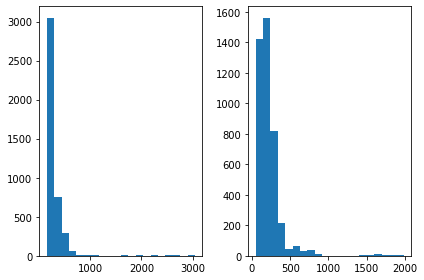

In [49]:
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)
axs[0].hist(score_TITIN_HUMAN.values, bins=n_bins)
axs[1].hist(align_len_TITIN_HUMAN.values, bins=n_bins)
#score_TITIN_HUMAN.plot(x="Score",y="Value")

La mayoría de alineamientos tendra scores menores a 500. También se observa que los alineamientos positivos de mayor frecuencia son menores a 500 aa y hay alineamientos que tienen hasta 2000 aa. Esto indicaría que el tamaño de la proteína TITIN_HUMAN es bastante grande, considerando que el tamaño de las proteínas eucariotas es una media de 472 aa 

In [50]:
filter_blastp_df[filter_blastp_df["qseqid"]=="sp|Q8WZ42|TITIN_HUMAN"].sort_values("positive",ascending= False).head(5)

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
25790,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,34350,7968,4478,10,9288,4735,2221,0.0,5028,1983
25796,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,34350,7968,4664,10,9454,4695,1946,0.0,5001,1947
25792,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,34350,7968,4381,8,8984,4526,2136,0.0,4789,1891
25791,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,34350,7968,4317,40,8837,4475,2198,0.0,4710,1883
25793,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,34350,7968,5319,9,9862,4437,2100,0.0,4759,1876


Esto podría indicar que el tamaño de la proteína esta vinculado con el número de alineamientos de manera proporcional. Para saber si los valores de longitud de proteína y tamaño están relacionadas, se calculará su correlación, se usará la correlación de Spearman debido a que no se puede afirmar una distribución normal en los datos.

In [57]:
len_freq = filter_blastp_df.groupby(["qseqid","qlen"],as_index=False)["qseqid"].count().sort_values("qseqid",ascending=False)
len_freq.head(5)

,qlen,qseqid
444,34350,4232
480,5635,2213
550,4349,1743
459,500,1415
401,782,1392


In [73]:
x = len_freq["qlen"]
y = len_freq["qseqid"]

In [75]:
spearmanr(x,y)

SpearmanrResult(correlation=0.158979794176913, pvalue=9.704641886185162e-05)

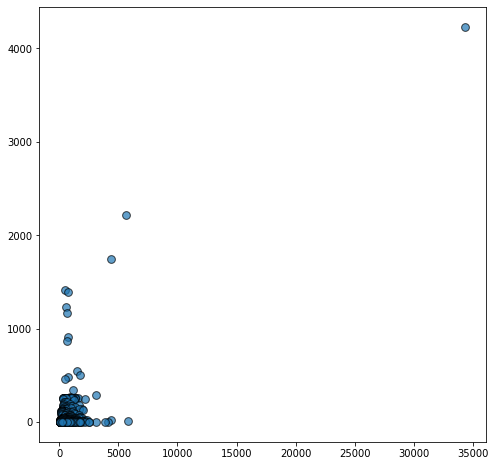

In [65]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")
#ax.plot(x, y_pred, color="k", lw=2.5)

La correlación es aproximadamente 0.1 indicando que no hay una relación directamente proporcional entre la longitud de la proteína y el número de alineamientos. En la gráfica también se puede visualizar que a pesar de que la proteína más grande es la que presenta un mayor número de alineamientos, las demás proteínas no presentan una relación lineal entre su logitud y número de alineamientos.

### Búsqueda de dominios funcionales en el subset de proteínas de interés

In [61]:
query_str = ""
for record in SeqIO.parse(query_file,"fasta"):
    seq_id = record.id
    if (seq_id in candidate_genes):
        seq_str = str(record.seq)
        query_str+= ">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

In [40]:
submit_data = {"email":"ana.romani1@unmsm.edu.pe",
               "title":"proteins_melanoma",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

In [41]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

In [42]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

In [43]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

In [44]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [45]:
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230313-131324-0229-49232315-p1m


In [81]:
progress_request     = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


In [82]:
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [83]:
print(results_log_request.text)

13/03/2023 13:13:50:167 Welcome to InterProScan-5.61-93.0
13/03/2023 13:13:50:168 Running InterProScan v5 in STANDALONE mode... on Linux
13/03/2023 13:13:57:282 RunID: hh-wp-02-12.ebi.ac.uk_20230313_131356958_i75d
13/03/2023 13:14:09:993 Loading file /nfs/public/rw/es/projects/wp-jdispatcher/logs/prod/sources/jobs/iprscan5/rest/20230313/1312/iprscan5-R20230313-131324-0229-49232315-p1m.sequence
13/03/2023 13:14:09:996 Running the following analyses:
[AntiFam-7.0,CDD-3.20,Coils-2.2.1,FunFam-4.3.0,Gene3D-4.3.0,Hamap-2021_04,MobiDBLite-2.0,PANTHER-17.0,Pfam-35.0,Phobius-1.01,PIRSF-3.10,PIRSR-2021_05,PRINTS-42.0,ProSitePatterns-2022_05,ProSiteProfiles-2022_05,SFLD-4,SignalP_EUK-4.1,SignalP_GRAM_NEGATIVE-4.1,SignalP_GRAM_POSITIVE-4.1,SMART-9.0,SUPERFAMILY-1.75,TIGRFAM-15.0,TMHMM-2.0c]
Available matches will be retrieved from the pre-calculated match lookup service.

Matches for any sequences that are not represented in the lookup service will be calculated locally.
13/03/2023 13:21:11:189 87

In [84]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)

In [88]:
results_df.to_csv("results_interproscan_query.tsv",sep='\t',index=False)

In [76]:
all_domains=pd.read_csv("results_interproscan_query.tsv",sep='\t')

In [77]:
all_domains.head()

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,PANTHER,PTHR19964,MULTIPLE PDZ DOMAIN PROTEIN,24,678,3.0E-141,T,13-03-2023,-,-
1,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,609,686,1.6E-16,T,13-03-2023,IPR001478,PDZ domain
2,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,477,556,3.6E-13,T,13-03-2023,IPR001478,PDZ domain
3,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,243,318,9.0E-18,T,13-03-2023,IPR001478,PDZ domain
4,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,349,422,9.5E-17,T,13-03-2023,IPR001478,PDZ domain


Se procedera a un filtrado por un valor e-value de 1e-9 

In [13]:
all_domains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18145 entries, 0 to 18144
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sequence        18145 non-null  object
 1   md5             18145 non-null  object
 2   length          18145 non-null  int64 
 3   database        18145 non-null  object
 4   accession       18145 non-null  object
 5   description     18145 non-null  object
 6   start           18145 non-null  int64 
 7   end             18145 non-null  int64 
 8   evalue          18145 non-null  object
 9   post_processed  18145 non-null  object
 10  date            18145 non-null  object
 11  entry           18145 non-null  object
 12  name            18145 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.8+ MB


Debido a que el tipo de datos de e-value no se han leído como valores númericos se los transformara

In [78]:
convert_num = pd.Series(all_domains["evalue"])
check=convert_num.str.split("E-")
def evalue_conversion(element):
    try:
        pd.reset_option('display.float_format')
        num = float(element[0])*(10**(-int(element[1])))
    except:
        num = "no_processed"
    return num
pd.reset_option('display.float_format', '{:.1E}'.format)
check_2 = check.apply(evalue_conversion)

In [15]:
check_2

0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0
             ...     
18140             0.0
18141    no_processed
18142             0.0
18143             0.0
18144    no_processed
Name: evalue, Length: 18145, dtype: object

In [79]:
all_domains["evalue"]=check_2
all_domains = all_domains[all_domains["evalue"]!="no_processed"]

In [80]:
pd.to_numeric(all_domains["evalue"])

0        3.000000e-141
1         1.600000e-16
2         3.600000e-13
3         9.000000e-18
4         9.500000e-17
             ...      
18137     3.000000e-67
18139     4.400000e-93
18140     5.200000e-66
18142     2.000000e-43
18143     1.100000e-13
Name: evalue, Length: 10204, dtype: float64

In [81]:
all_domains.head(4)

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,PANTHER,PTHR19964,MULTIPLE PDZ DOMAIN PROTEIN,24,678,0.0,T,13-03-2023,-,-
1,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,609,686,0.0,T,13-03-2023,IPR001478,PDZ domain
2,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,477,556,0.0,T,13-03-2023,IPR001478,PDZ domain
3,sp|Q8N448|LNX2_HUMAN,4b9ca3d3b6b17132cab42a4f37472d1a,690,SMART,SM00228,pdz_new,243,318,0.0,T,13-03-2023,IPR001478,PDZ domain


In [82]:
all_domains_filter = all_domains[all_domains["evalue"]<=1e-9]

In [83]:
all_domains.shape

(10204, 13)

In [84]:
all_domains_filter.shape

(8891, 13)

In [85]:
pd.DataFrame(all_domains_filter["accession"].value_counts().head(10))

,accession
G3DSA:2.60.40.10,431
SSF48726,236
PF07679,171
cd00063,152
SM00060,138
PF00041,134
SSF49265,101
PR00449,94
PR00109,88
SSF56112,76


El dominio que se ha predicho con mayor frecuencia dentro de las proteínas relacionadas con melanoma es G3DSA:2.60.40.10

### Análisis de los resultados de BLAST e Interproscan

Se procedera a unir los resultados de BLAST con InterProScan

In [86]:
# Generate table of variations
all_table = filter_blastp_df.merge(all_domains_filter,left_on="qseqid",right_on="sequence")

In [87]:
all_table.shape

(7747778, 25)

Se hara un filtro con respecto a los alineamientos que tengan dentro los dominios

In [88]:
all_table_copy = all_table.copy()

In [89]:
all_table_copy = all_table_copy[(all_table_copy["start"]>=all_table_copy["qstart"]) &(all_table_copy["end"]<=all_table_copy["qend"])]

In [90]:
all_table.shape[0]-all_table_copy.shape[0]

7310195

In [91]:
all_table_copy.head(5)

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue_x,...,database,accession,description,start,end,evalue_y,post_processed,date,entry,name
0,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,...,SUPERFAMILY,SSF48726,Immunoglobulin,3,118,0.0,T,13-03-2023,IPR036179,Immunoglobulin-like domain superfamily
1,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,...,PANTHER,PTHR23411,TAPASIN,8,131,0.0,T,13-03-2023,-,-
2,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,...,CDD,cd05769,IgC1_TCR_beta,6,125,0.0,T,13-03-2023,-,-
3,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,...,FunFam,G3DSA:2.60.40.10:FF:001090,T cell receptor beta constant 1,1,129,0.0,T,13-03-2023,-,-
4,sp|A0A5B9|TRBC2_HUMAN,sp|P0DTU4|TRBR2_HUMAN,178,315,1,138,178,315,958,5.000000e-131,...,Gene3D,G3DSA:2.60.40.10,Immunoglobulins,1,129,0.0,T,13-03-2023,IPR013783,Immunoglobulin-like fold


In [35]:
proteins_melanoma = all_table_copy["qseqid"].unique().tolist()
proteins_ref = all_table_copy["sseqid"].unique().tolist()
print(len(proteins_melanoma),len(proteins_ref))

572 4716


Se encontró que 572 proteínas relacionadas a melanoma que se alinean con 4716 proteínas del proteoma humano en secciones de predicción de los dominios

In [92]:
domains_freq = all_table_copy.groupby(["qseqid","sseqid"],as_index=False)["accession"].value_counts().sort_values("count",ascending=False)
domains_freq

,qseqid,sseqid,accession,count
64099,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10,960
64100,sp|Q8WZ42|TITIN_HUMAN,sp|Q5VST9|OBSCN_HUMAN,SSF48726,923
77321,sp|Q96RW7|HMCN1_HUMAN,sp|Q8WZ42|TITIN_HUMAN,G3DSA:2.60.40.10,912
77322,sp|Q96RW7|HMCN1_HUMAN,sp|Q8WZ42|TITIN_HUMAN,SSF48726,893
65063,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,G3DSA:2.60.40.10,800
...,...,...,...,...
35109,sp|Q00534|CDK6_HUMAN,sp|O94921|CDK14_HUMAN,PTHR24056,1
35108,sp|Q00534|CDK6_HUMAN,sp|O94921|CDK14_HUMAN,SM00220,1
35107,sp|Q00534|CDK6_HUMAN,sp|O94921|CDK14_HUMAN,SSF56112,1
35106,sp|Q00534|CDK6_HUMAN,sp|O94921|CDK14_HUMAN,PF00069,1


El dominio con un mayor número de predicciones fue G3DSA:2.60.40.10	 en la proteina TITIN_Human con OBSCN_HUMAN siendo luego SSF48726 con el mismo alineamiento, ambos dominios estan relacionados a la superfamilia de Immunoglobulinas. 

### Analisis de la proteína TITIN_Human

Los resultados muestran que esta proteína es la que presenta un mayor número de alineamientos, además de ser la proteína más grande (34350 aa) relacionada a melanoma. Por otro lado es la que presenta un mayor número de predicciones de dominio. Por lo tanto a continuación se analizára los dominios encontrados en la proteína y las proteínas que presentaron alineamientos en sus respectivos dominios. Los alineamientos que se analizarán serán los que al menos se hayan alineado en 1/18 del tamaño de la proteína

Descripción de TITIN_HUMAN:

Es una proteína estructural. Componente clave en el ensamblaje y funcionamiento de los músculos estriados de los vertebrados. Se ha relacionado a melanoma debido al encuentro de mutaciones de está proteína en células tumorales de melanoma.

In [97]:
all_table_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437583 entries, 0 to 7747764
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   qseqid          437583 non-null  object 
 1   sseqid          437583 non-null  object 
 2   qlen            437583 non-null  int64  
 3   slen            437583 non-null  int64  
 4   qstart          437583 non-null  int64  
 5   sstart          437583 non-null  int64  
 6   qend            437583 non-null  int64  
 7   send            437583 non-null  int64  
 8   score           437583 non-null  int64  
 9   evalue_x        437583 non-null  float64
 10  length_x        437583 non-null  int64  
 11  positive        437583 non-null  int64  
 12  sequence        437583 non-null  object 
 13  md5             437583 non-null  object 
 14  length_y        437583 non-null  int64  
 15  database        437583 non-null  object 
 16  accession       437583 non-null  object 
 17  descripti

In [118]:
TITIN_HUMAN_tab_filter = all_table_copy[(all_table_copy["qseqid"]=="sp|Q8WZ42|TITIN_HUMAN") & (all_table_copy["positive"]>=1750)]

In [124]:
TITIN_HUMAN_tab_filter.head(6)

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue_x,...,database,accession,description,start,end,evalue_y,post_processed,date,entry,name
504098,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,SUPERFAMILY,SSF48726,Immunoglobulin,8232,8332,0.0,T,13-03-2023,IPR036179,Immunoglobulin-like domain superfamily
504107,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,SUPERFAMILY,SSF48726,Immunoglobulin,6440,6539,0.0,T,13-03-2023,IPR036179,Immunoglobulin-like domain superfamily
504111,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,CDD,cd00096,Ig,5058,5126,0.0,T,13-03-2023,-,-
504122,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,CDD,cd00096,Ig,5337,5404,0.0,T,13-03-2023,-,-
504123,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,CDD,cd00096,Ig,7119,7186,0.0,T,13-03-2023,-,-
504125,sp|Q8WZ42|TITIN_HUMAN,sp|Q96RW7|HMCN1_HUMAN,34350,5635,5058,448,9159,4516,3044,0.0,...,SUPERFAMILY,SSF48726,Immunoglobulin,8326,8419,0.0,T,13-03-2023,IPR036179,Immunoglobulin-like domain superfamily


In [119]:
TITIN_HUMAN_tab_filter["sseqid"].unique()

array(['sp|Q96RW7|HMCN1_HUMAN', 'sp|Q5VST9|OBSCN_HUMAN'], dtype=object)

Las únicas proteínas que tiene un alineamiento que es mayor o igual al 1/20 del tamaño de la proteína son HMCN1_HUMAN y OBSCN_HUMAN. Ambas proteínas están vinculadas a funciones estructurales.

In [120]:
TITIN_HUMAN_tab_filter["accession"].nunique()

15

In [125]:
TITIN_HUMAN_tab_filter.groupby("sseqid", as_index=False)["accession"].value_counts()

,sseqid,accession,count
0,sp|Q5VST9|OBSCN_HUMAN,SSF48726,291
1,sp|Q5VST9|OBSCN_HUMAN,PF07679,290
2,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10,288
3,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10:FF:000022,238
4,sp|Q5VST9|OBSCN_HUMAN,cd00096,105
5,sp|Q5VST9|OBSCN_HUMAN,SM00408,73
6,sp|Q5VST9|OBSCN_HUMAN,SM00409,55
7,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10:FF:000218,34
8,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10:FF:000107,6
9,sp|Q5VST9|OBSCN_HUMAN,G3DSA:2.60.40.10:FF:001804,4


Hay presencia de 15 dominios predichos en TITIN_HUMAN, en los alineamientos se observa que el dominio predicho más presente en la proteína TITIN es SSF48726, siendo un dominio característico de las immunoglobulinas.

## Resumen de los resultados

* Existen 725 proteínas relacionadas a melanoma en Uniprot
* No hay correlación entre el tamaño de la proteína y el número de alineamientos realizados en BLAST
* La proteína relacionada a melanoma con un mayor número de alineamientos con otras proteínas fue TITIN_HUMAN
* Las proteínas alineadas en mas o igual a un 1/20 de la secuencia proteíca de TITIN_HUMAN fueron HMCN1_HUMAN y OBSCN_HUMAN
* El dominio más frecuente en la predicción realizada por InterProSCan fue SSF48726.

## Conclusiones y Observaciones

* Existe un número relativamente alto de proteínas relacionadas a melanoma.
* Hay un gran número de alineamientos locales que presentan predicciones de dominios.
* No se encontraron alineamientos entre TITIN_HUMAN con otras proteínas del proteoma humano que fueran al menos 1/3 de la proteína. 
* La predicción de los dominios indican funciones que no se han encontrado en la proteína TITIN_HUMAN.